<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DSAssignment_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Objective: 

You'll be chasing down robots for an online auction site. Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.
In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, ***including bid frequency over short periods of time, has proven insufficient***. 
The goal is to identify “robots” which are making bids, helping the site owners easily **flag these users for removal from their site to prevent unfair auction activity.** 


In [ ]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

## Load the Data

### BIDS Data

In [ ]:
root_dir = "drive/MyDrive/DS Assignment v1/"

In [ ]:
df_bids = pd.read_csv(root_dir + "bids.csv")
df_bids.shape

(7656334, 9)

In [ ]:
df_bids_org = df_bids

In [ ]:
# df_bids = df_bids_org

In [ ]:
df_bids['time'] = pd.to_datetime(df_bids['time'])
df_bids['time_hour'] = df_bids['time'].apply(lambda x: str(x.hour))

In [ ]:
df_bids[[ 'bidder_id', 'device', 'country', 'ip', 'time_hour', 'auction', 'url', 'merchandise' ]].drop_duplicates().shape

(6838014, 8)

In [ ]:
df_bids = df_bids[[ 'bidder_id' , 'device' , 'country' , 'ip' , 'time_hour' , 'auction' , 'url' , 'merchandise' ]].drop_duplicates()

In [ ]:
df_bids.head()

,bidder_id,device,country,ip,time_hour,auction,url,merchandise
0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,phone0,us,69.166.231.58,22,ewmzr,vasstdc27m7nks3,jewelry
1,668d393e858e8126275433046bbd35c6tywop,phone1,in,50.201.125.84,22,aeqok,jmqlhflrzwuay9c,furniture
2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,phone2,py,112.54.208.157,22,wa00e,vasstdc27m7nks3,home goods
3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,phone4,in,18.99.175.133,22,jefix,vasstdc27m7nks3,jewelry
4,8393c48eaf4b8fa96886edc7cf27b372dsibi,phone5,in,145.138.5.37,22,jefix,vasstdc27m7nks3,jewelry


In [ ]:
df_bids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6838014 entries, 0 to 7656333
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   bidder_id    object
 1   device       object
 2   country      object
 3   ip           object
 4   time_hour    object
 5   auction      object
 6   url          object
 7   merchandise  object
dtypes: object(8)
memory usage: 469.5+ MB


In [ ]:
df_bids.describe()

,bidder_id,device,country,ip,time_hour,auction,url,merchandise
count,6838014,6838014,6829403,6838014,6838014,6838014,6838014,6838014
unique,6614,7351,199,2303991,15,15051,1786351,10
top,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,phone4,in,37.95.134.218,14,jqx39,vasstdc27m7nks3,mobile
freq,419428,478209,1677224,43977,710669,486687,2816412,1855027


In [ ]:
df_bids.country.isnull().groupby([df_bids["merchandise"]]).sum().reset_index(name="count").sort_values("count",0, False)

,merchandise,count
6,jewelry,2795
7,mobile,1932
5,home goods,1831
9,sporting goods,758
4,furniture,487
8,office equipment,485
2,clothing,217
1,books and music,103
3,computers,3
0,auto parts,0


In [ ]:
df_bids.country.isnull().groupby([df_bids["device"]]).sum().reset_index(name="count").sort_values("count",0, False)[:300]

,device,count
280,phone125,548
113,phone11,508
558,phone150,402
69,phone106,393
5812,phone63,380
...,...,...
2675,phone341,1
1703,phone2531,1
995,phone1894,1
624,phone156,1


In [ ]:
#Fill missing country by mode on merchandise
df_bids_merc_cty = df_bids.groupby(['merchandise','country']).size().reset_index(name="count")
for merc in df_bids['merchandise'].unique():
  max_count = df_bids_merc_cty[df_bids_merc_cty['merchandise']==merc]['count'].max()
  cty = df_bids_merc_cty[(df_bids_merc_cty['merchandise']==merc) & (df_bids_merc_cty['count']==max_count)]['country'].values[0]
  print(cty)
  df_bids.loc[(df_bids['merchandise']==merc) & (df_bids['country'].isnull()) , 'country' ] = cty


in
in
in
in
in
in
th
in
in
in


In [ ]:
df_bids.isnull().sum()

bidder_id      0
device         0
country        0
ip             0
time_hour      0
auction        0
url            0
merchandise    0
dtype: int64

In [ ]:
df_bids.columns

Index(['bidder_id', 'device', 'country', 'ip', 'time_hour', 'auction', 'url',
       'merchandise'],
      dtype='object')

In [ ]:
country_csv = "https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv"
df_country = pd.read_csv(country_csv)
df_country['Two_Letter_Country_Code'] = df_country['Two_Letter_Country_Code'].str.lower()
df_country.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",af,AFG,4.0
1,Europe,EU,"Albania, Republic of",al,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),aq,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",dz,DZA,12.0
4,Oceania,OC,American Samoa,as,ASM,16.0


In [ ]:
df_bids = pd.merge(df_bids,df_country, left_on="country", right_on="Two_Letter_Country_Code")

In [ ]:
df_bids.isnull().sum()

bidder_id                         0
device                            0
country                           0
ip                                0
time_hour                         0
auction                           0
url                               0
merchandise                       0
Continent_Name                    0
Continent_Code               475992
Country_Name                      0
Two_Letter_Country_Code           0
Three_Letter_Country_Code         0
Country_Number                    0
dtype: int64

In [ ]:
df_bids.groupby('Continent_Name').size().reset_index(name="count").sort_values("count",0, False).reset_index(drop=True)

,Continent_Name,count
0,Asia,3943703
1,Africa,1533154
2,Europe,1042914
3,North America,475992
4,South America,178406
5,Oceania,34780


In [ ]:
df_bids.columns

Index(['bidder_id', 'device', 'country', 'ip', 'time_hour', 'auction', 'url',
       'merchandise', 'Continent_Name', 'Continent_Code', 'Country_Name',
       'Two_Letter_Country_Code', 'Three_Letter_Country_Code',
       'Country_Number'],
      dtype='object')

In [ ]:
df_bids.columns = df_bids.columns.str.strip().str.lower()
df_bids = df_bids[['bidder_id', 'device','continent_name', 'country_name', 'country', 'ip', 'time_hour', 'auction', 'url','merchandise']]

In [ ]:
df_bids.head()

,bidder_id,device,continent_name,country_name,country,ip,time_hour,auction,url,merchandise
0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,phone0,North America,United States of America,us,69.166.231.58,22,ewmzr,vasstdc27m7nks3,jewelry
1,c4856fd5abe8f6d6dea36ca2fec444faauos8,phone18,North America,United States of America,us,161.0.93.123,22,2hkjh,9vr179ujwjgoxt3,jewelry
2,708ba5d36271639a9003ace4dc2cc540mugek,phone27,North America,United States of America,us,196.99.84.184,22,ewmzr,a1qvn2e5zlg48fw,mobile
3,52d8066e28f168e5bee769559ead307e1go7e,phone33,North America,United States of America,us,240.205.85.43,22,165y9,azl6m5i5tg78c2j,mobile
4,6c8ffec692e88d81e1b18d47818abb04v6llr,phone8,North America,United States of America,us,160.9.191.22,22,ewmzr,lok9xfe6k6rtv8f,home goods


### Bidder Data

In [ ]:
#Train - Labeled
df_train = pd.read_csv(root_dir + "train.csv")
print(df_train.shape)
df_train_org = df_train

(1498, 5)


In [ ]:
df_train.sample(5,weights="robot_act_prob_lk")

,bidder_id,payment_account,address,robot_act_prob_lk,outcome
631,c6a49cf5944626b45425712f9e19e91d2nyh7,a3d2de7675556553a5f08e4c88d2c228w79qb,966b691f70dfc7b2ce12af8df14a8ad5qhboc,0.857,1
1131,8f086b809805064f3c4a5dd48327c0f51yplz,644165a0f0b4adf062587f8c5a7a1a4ah4wmt,6aee0bf71520b4a73dc068d93712a5cfq2hkp,0.857,1
719,ae6758a627a111f6d6b530b0154c429566o4k,7d5b54f56c8c20b69def03d917574ad6qpim4,6d82a9e4d2ca2cfff002460b074b546cosadk,0.857,1
775,bd0071b98d9479130e5c053a244fe6f1muj8h,124fa309fce08269cce18a84a4588729fjf18,dee44a87c5db48c9f6ca23e37d6f61074typq,0.857,1
784,2d9579812895729581ce269ea17462197jxvy,a3d2de7675556553a5f08e4c88d2c228vknp9,ca8d4b018cb62966eebb2974f5a83b4fcmv7d,0.857,1


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bidder_id          1498 non-null   object 
 1   payment_account    1498 non-null   object 
 2   address            1498 non-null   object 
 3   robot_act_prob_lk  1498 non-null   float64
 4   outcome            1498 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 58.6+ KB


In [ ]:
df_train.describe()

,robot_act_prob_lk,outcome
count,1498.000000,1498.000000
mean,0.040047,0.046729
std,0.180937,0.211128
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.857000,1.000000


In [ ]:
print("Unique ",df_train['bidder_id'].unique().shape,df_train['payment_account'].unique().shape,df_train['address'].unique().shape)

Unique  (1498,) (1498,) (1498,)


In [ ]:
df_train = df_train[['bidder_id','robot_act_prob_lk','outcome']]

In [ ]:
df_train[df_train['robot_act_prob_lk'] == 0.0]['outcome'].max()

0

In [ ]:
df_train[df_train['robot_act_prob_lk'] > 0.0]['outcome'].max()

1

In [ ]:
#Test
df_test = pd.read_csv(root_dir + "test.csv")
print(df_test.shape)
df_test_org = df_test

(515, 4)


In [ ]:
df_test.sample(5,weights="robot_act_prob_lk")

,bidder_id,payment_account,address,robot_act_prob_lk
25,6affd6d2976aa7c48dac70612fc8e31ddo7j5,a3d2de7675556553a5f08e4c88d2c228k8x6u,5e2f0a6e77f8fa7cac429738e58978a0y5m8e,0.857
288,67a1b129ca241c51d0abb5484f8eb3fct8o5c,a12ba564b8f968acf2efcee7087d8e4defyfl,6876549ce8193a2e92a84a50141701c4f86k4,0.857
275,37bb1697e1c3922a06c2d2ea4138a4c8s6wgk,a3d2de7675556553a5f08e4c88d2c2289narx,274a03538f87ee7ec8b091da1c4fa8fcnxf05,0.857
161,6bdb40330295fb3abd4647808c319d29pb29n,a3d2de7675556553a5f08e4c88d2c228xx5eg,794abfcfc9a51569c6415a61a319b35295ssk,0.857
36,19b39b852ed4abf1ba5b095829e25b946aed1,a3d2de7675556553a5f08e4c88d2c2288as1g,8d390fcde5a6d3d8def38ab48875c23f3jb6e,0.857


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bidder_id          515 non-null    object 
 1   payment_account    515 non-null    object 
 2   address            515 non-null    object 
 3   robot_act_prob_lk  515 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.2+ KB


In [ ]:
df_test.describe()

,robot_act_prob_lk
count,515.000000
mean,0.054915
std,0.210076
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.857000


In [ ]:
print("Unique ",df_test['bidder_id'].unique().shape,df_test['payment_account'].unique().shape,df_test['address'].unique().shape)

Unique  (515,) (515,) (515,)


In [ ]:
df_test['actual_outcome'] = df_test['robot_act_prob_lk'].apply(lambda x: 1 if x > 0.0 else 0)

In [ ]:
df_test = df_test[['bidder_id','robot_act_prob_lk','actual_outcome']]

In [ ]:
df_test['actual_outcome'].value_counts()

0    482
1     33
Name: actual_outcome, dtype: int64

## Merge the BIDS and BIDDER

In [ ]:
df_bids_train = pd.merge(df_bids,df_train, on ="bidder_id", how="inner")
df_bids_train.shape

(1362977, 12)

In [ ]:
df_bids_train.isnull().sum()

bidder_id            0
device               0
continent_name       0
country_name         0
country              0
ip                   0
time_hour            0
auction              0
url                  0
merchandise          0
robot_act_prob_lk    0
outcome              0
dtype: int64

In [ ]:
df_bids_test = pd.merge(df_bids,df_test, on ="bidder_id", how="inner")
df_bids_test.shape

(1430235, 12)

In [ ]:
df_bids_test.isnull().sum()

bidder_id            0
device               0
continent_name       0
country_name         0
country              0
ip                   0
time_hour            0
auction              0
url                  0
merchandise          0
robot_act_prob_lk    0
actual_outcome       0
dtype: int64

In [ ]:
#checking whether the bidder in train is present in test
df_test[df_test['bidder_id'].isin(df_train['bidder_id'].unique())]

,bidder_id,robot_act_prob_lk,actual_outcome


In [ ]:
df_bids_train['data']='train'
df_bids_test['data']='test'

## Exploratory

In [ ]:
print("Bidders",df_bids['bidder_id'].unique().shape, df_train['bidder_id'].unique().shape,df_test["bidder_id"].unique().shape)
print("*"*100)
print("Outcome")
print("*"*10)
print(df_train['outcome'].value_counts())

Bidders (6578,) (1498,) (515,)
****************************************************************************************************
Outcome
**********
0    1428
1      70
Name: outcome, dtype: int64


bids has less than the actual bidders in train and test

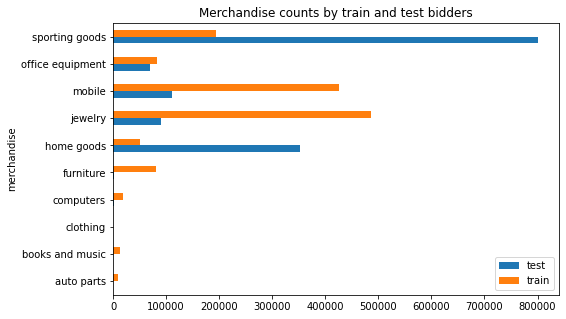

In [ ]:
mer_cnt_train = df_bids_train.groupby(['merchandise','data']).size().reset_index(name="count")
mer_cnt_test = df_bids_test.groupby(['merchandise','data']).size().reset_index(name="count")

mer_cnt = pd.concat([mer_cnt_train,mer_cnt_test],axis=0)

df_pivot_mer = pd.pivot_table(mer_cnt,values="count",index="merchandise",columns="data")

fig,ax = plt.subplots(figsize=(8,5))
df_pivot_mer.plot(kind="barh",stacked=False,ax=ax)
ax.set_title("Merchandise counts by train and test bidders")
plt.legend(loc='lower right')

In [ ]:
print("Unique countries in Train and Test")
cty_train = df_bids_train['country'].unique()
cty_test = df_bids_test['country'].unique()
print("Train\n\n",cty_train,"\n\n", len(cty_train) )
print("*"*100)
print("\nTest\n\n",cty_test,"\n\n", len(cty_test) )

Unique countries in Train and Test
Train

 ['us' 'in' 'py' 'ru' 'th' 'id' 'za' 'ng' 'sd' 'au' 'np' 'bd' 'tr' 'fr'
 'pk' 'my' 'vn' 'gh' 'ua' 'pl' 'by' 'zm' 'lk' 'ph' 'br' 'mx' 'qa' 'nl'
 'gt' 'ae' 'no' 'hu' 'ml' 'sv' 'bn' 'cn' 'ye' 'tn' 'gr' 'at' 'cm' 'ca'
 'rs' 'sz' 'zw' 'de' 'cr' 'jo' 'sa' 'eg' 'hk' 'ug' 'sn' 'cl' 'ma' 'be'
 'al' 'bo' 'lt' 'bj' 'mu' 'cz' 'lu' 'ir' 'ci' 'mg' 'co' 'mc' 'do' 'hr'
 'iq' 'ch' 'ke' 'ro' 'ar' 'es' 'il' 'sg' 'az' 'dk' 'kw' 'it' 'ni' 'ge'
 'bh' 'ie' 'ec' 'si' 'se' 'om' 'fi' 'pa' 'uy' 'lb' 'pr' 'tt' 'cg' 'nz'
 've' 'uz' 'ht' 'tz' 'gm' 'mk' 'et' 'mw' 'ee' 'kr' 'mn' 'pe' 'sl' 'dz'
 'lv' 'kg' 'bb' 'sc' 'am' 'lr' 'bf' 'kh' 'md' 'ly' 'ba' 'ga' 'mr' 'jm'
 'ao' 'me' 'af' 'kz' 'hn' 'ls' 'cy' 'sk' 'la' 'dj' 'so' 'pt' 'gy' 'rw'
 'cv' 'ne' 'tg' 'sy' 'cd' 'sb' 'mz' 'tj' 'tw' 'mv' 'tm' 'ws' 'fj' 'bt'
 'pg' 'jp' 'td' 'bw' 'ps' 'mt' 'bg' 'gq' 'bi' 'mm' 'gu' 'cf' 'is' 'gl'
 'sr' 'bz' 'tl' 'mo' 'ag' 'dm' 're' 'li' 'bm' 'je' 'pf' 'bs' 'fo' 'er'
 'ad'] 

 183
********************

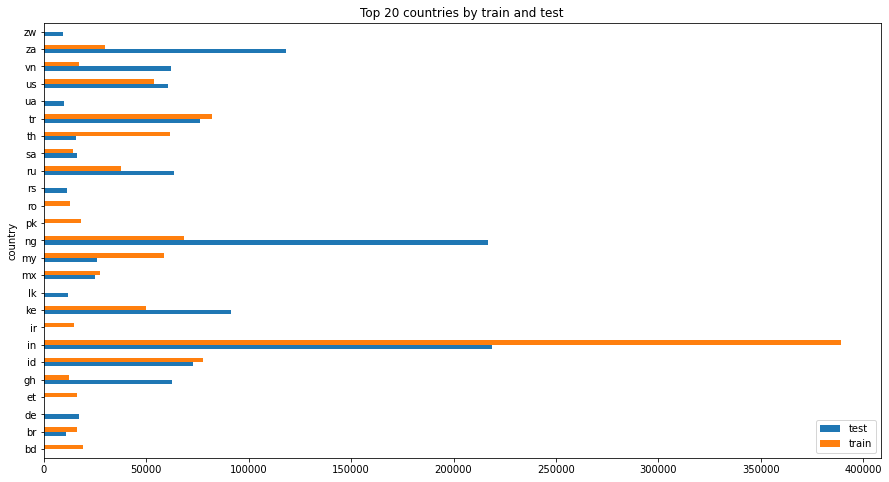

In [ ]:
cnt_train = df_bids_train.groupby(['country','data'])\
                             .size().reset_index(name="count")\
                             .sort_values("count",ascending=False)[:20]\
                             .sort_values("count",ascending=True)

cnt_test = df_bids_test.groupby(['country','data'])\
                           .size().reset_index(name="count")\
                           .sort_values("count",ascending=False)[:20]\
                           .sort_values("count",ascending=True)\

cty_cnt = pd.concat([cnt_train,cnt_test],axis=0)

df_pivot_cty = pd.pivot_table(cty_cnt,values="count",index="country",columns="data")

fig,ax = plt.subplots(figsize=(15,8))
df_pivot_cty.plot(kind="barh",stacked=False,ax=ax)
ax.set_title("Top 20 countries by train and test")
plt.legend(loc='lower right')

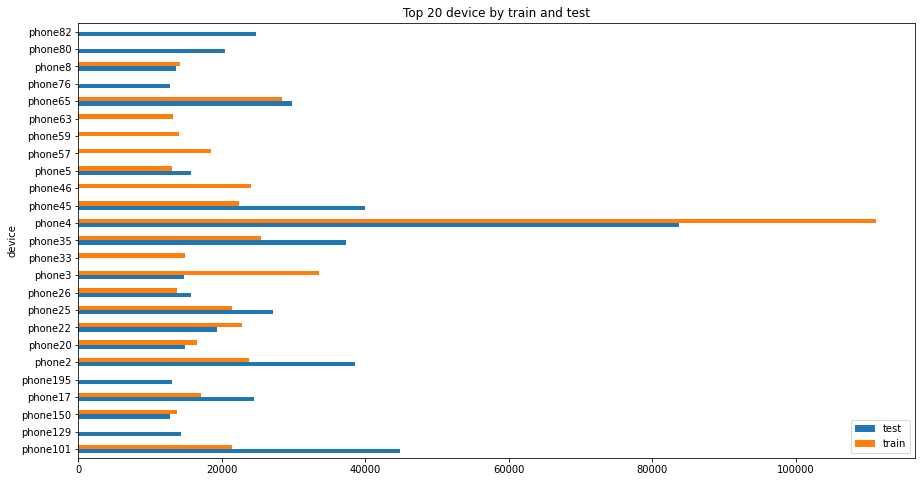

In [ ]:
cnt_train = df_bids_train.groupby(['device','data'])\
                             .size().reset_index(name="count")\
                             .sort_values("count",ascending=False)[:20]\
                             .sort_values("count",ascending=True)

cnt_test = df_bids_test.groupby(['device','data'])\
                           .size().reset_index(name="count")\
                           .sort_values("count",ascending=False)[:20]\
                           .sort_values("count",ascending=True)\

dev_cnt = pd.concat([cnt_train,cnt_test],axis=0)

df_pivot_dev = pd.pivot_table(dev_cnt,values="count",index="device",columns="data")

fig,ax = plt.subplots(figsize=(15,8))
df_pivot_dev.plot(kind="barh",stacked=False,ax=ax)
ax.set_title("Top 20 device by train and test")
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Merchandise mostly seen on bids in Top 20 auctions of train')

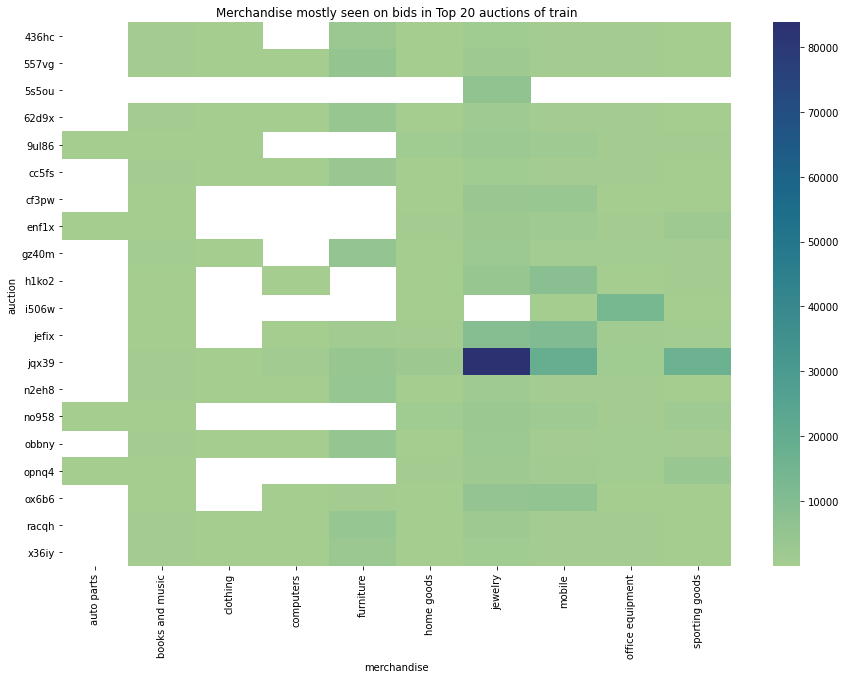

In [ ]:
auction_top = df_bids_train.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values

tmp = df_bids_train[df_bids_train['auction'].isin(auction_top)]\
.groupby(['auction','merchandise']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="merchandise"),cmap="crest",ax=ax)
ax.set_title("Merchandise mostly seen on bids in Top 20 auctions of train")

Text(0.5, 1.0, 'Merchandise mostly seen on bids in Top 20 auctions of test')

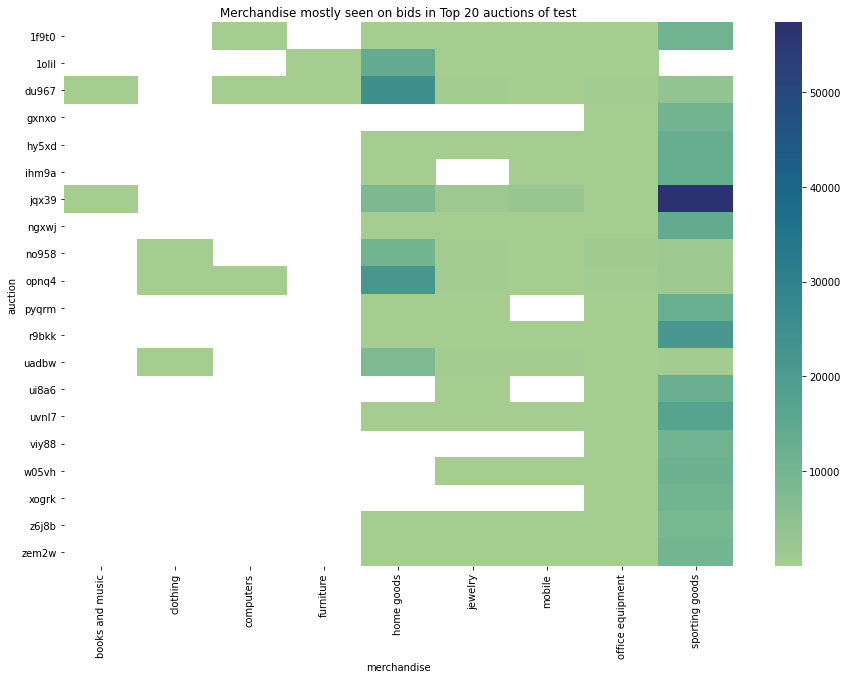

In [ ]:
auction_top = df_bids_test.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values

tmp = df_bids_test[df_bids_test['auction'].isin(auction_top)]\
.groupby(['auction','merchandise']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="merchandise"),cmap="crest",ax=ax)
ax.set_title("Merchandise mostly seen on bids in Top 20 auctions of test")

Text(0.5, 1.0, 'Top devices on top auctions in train')

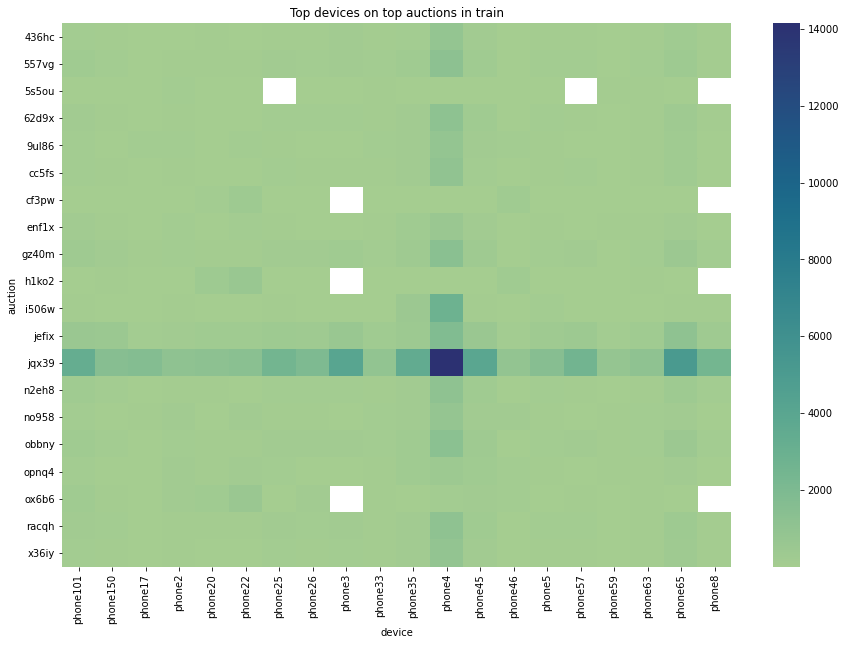

In [ ]:
auction_top = df_bids_train.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
device_top = df_bids_train.groupby(['device']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['device'].values

tmp = df_bids_train[(df_bids_train['auction'].isin(auction_top)) & (df_bids_train['device'].isin(device_top))]\
.groupby(['auction','device']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="device"),cmap="crest",ax=ax)
ax.set_title("Top devices on top auctions in train")

Text(0.5, 1.0, 'Top devices on top auctions in test')

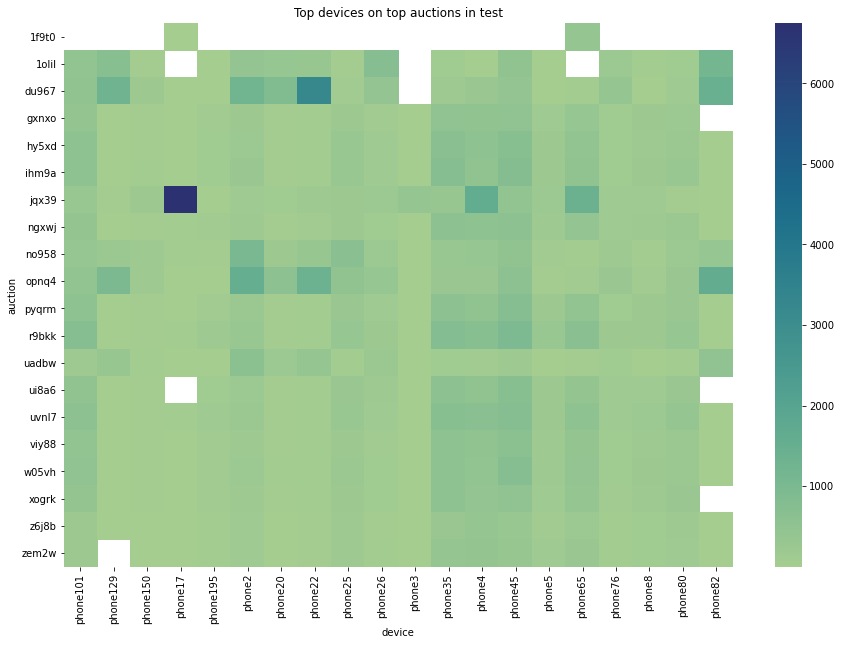

In [ ]:
auction_top = df_bids_test.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
device_top = df_bids_test.groupby(['device']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['device'].values

tmp = df_bids_test[(df_bids_test['auction'].isin(auction_top)) & (df_bids_test['device'].isin(device_top))]\
.groupby(['auction','device']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="device"),cmap="crest",ax=ax)
ax.set_title("Top devices on top auctions in test")

Text(0.5, 1.0, 'Countries on top auctions in train')

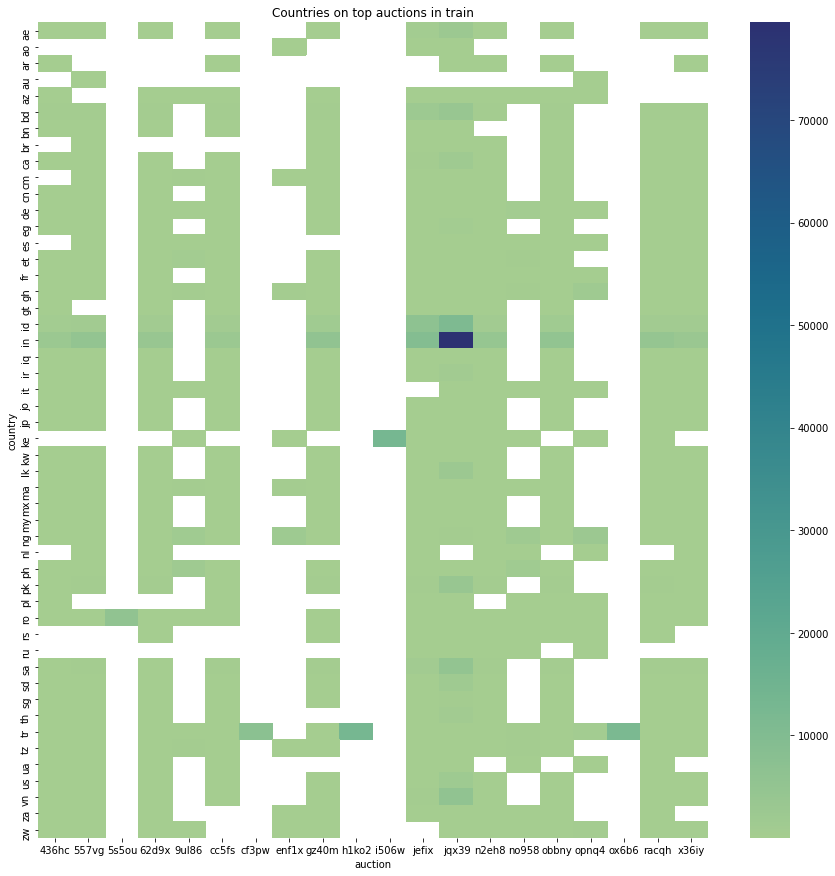

In [ ]:
auction_top = df_bids_train.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
cty_top = df_bids_train.groupby(['country']).size().reset_index(name="count").sort_values('count',ascending=False)[:50]['country'].values

tmp = df_bids_train[(df_bids_train['auction'].isin(auction_top)) & (df_bids_train['country'].isin(cty_top))]\
.groupby(['auction','country']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="country").T,cmap="crest",ax=ax)
ax.set_title("Countries on top auctions in train")

Text(0.5, 1.0, 'Countries on top auctions in test')

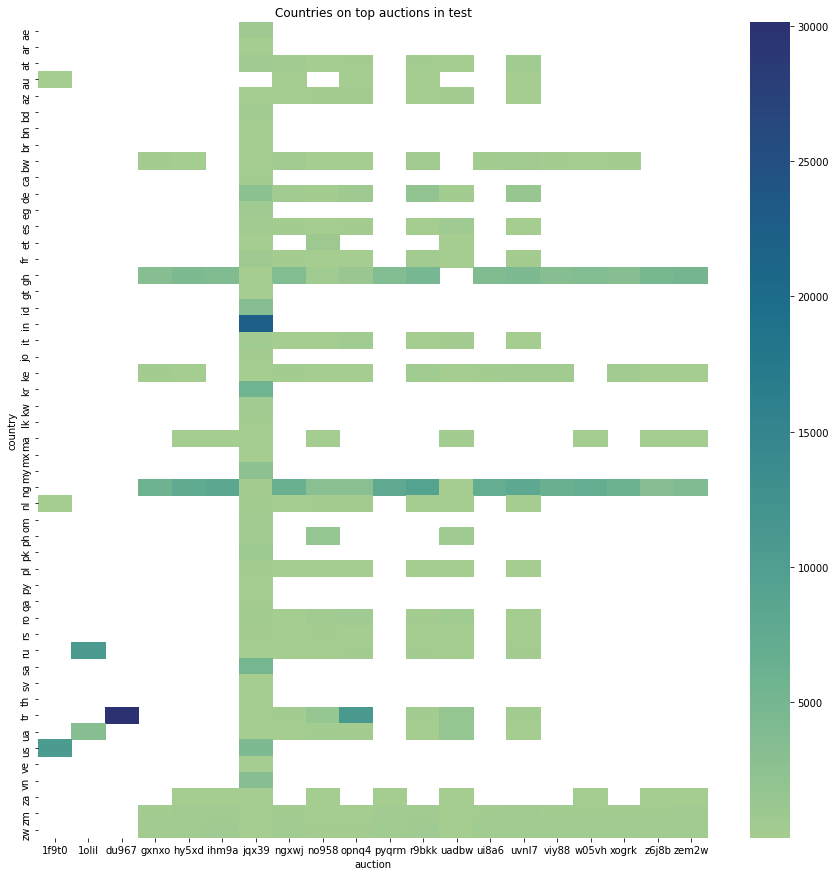

In [ ]:
auction_top = df_bids_test.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
cty_top = df_bids_test.groupby(['country']).size().reset_index(name="count").sort_values('count',ascending=False)[:50]['country'].values

tmp = df_bids_test[(df_bids_test['auction'].isin(auction_top)) & (df_bids_test['country'].isin(cty_top))]\
.groupby(['auction','country']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="country").T,cmap="crest",ax=ax)
ax.set_title("Countries on top auctions in test")

Text(0.5, 1.0, 'IP on top auctions in train')

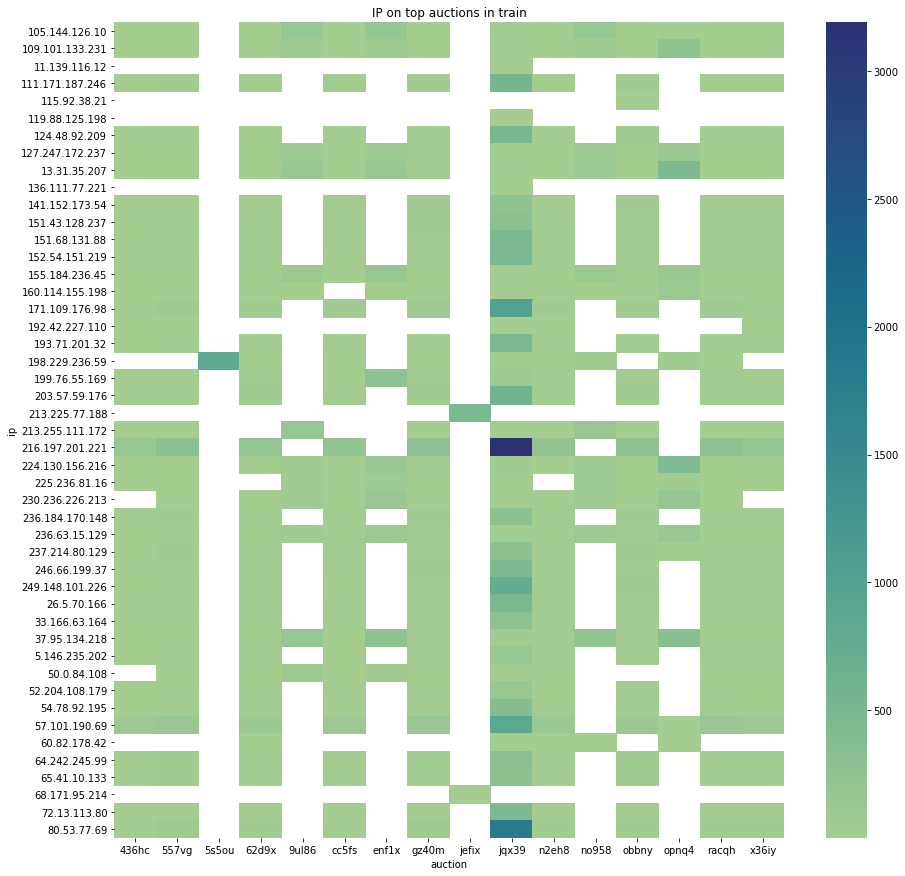

In [ ]:
auction_top = df_bids_train.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
ip_top = df_bids_train.groupby(['ip']).size().reset_index(name="count").sort_values('count',ascending=False)[:50]['ip'].values

tmp = df_bids_train[(df_bids_train['auction'].isin(auction_top)) & (df_bids_train['ip'].isin(ip_top))]\
.groupby(['auction','ip']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="ip").T,cmap="crest",ax=ax)
ax.set_title("IP on top auctions in train")

Text(0.5, 1.0, 'IP on top auctions in test')

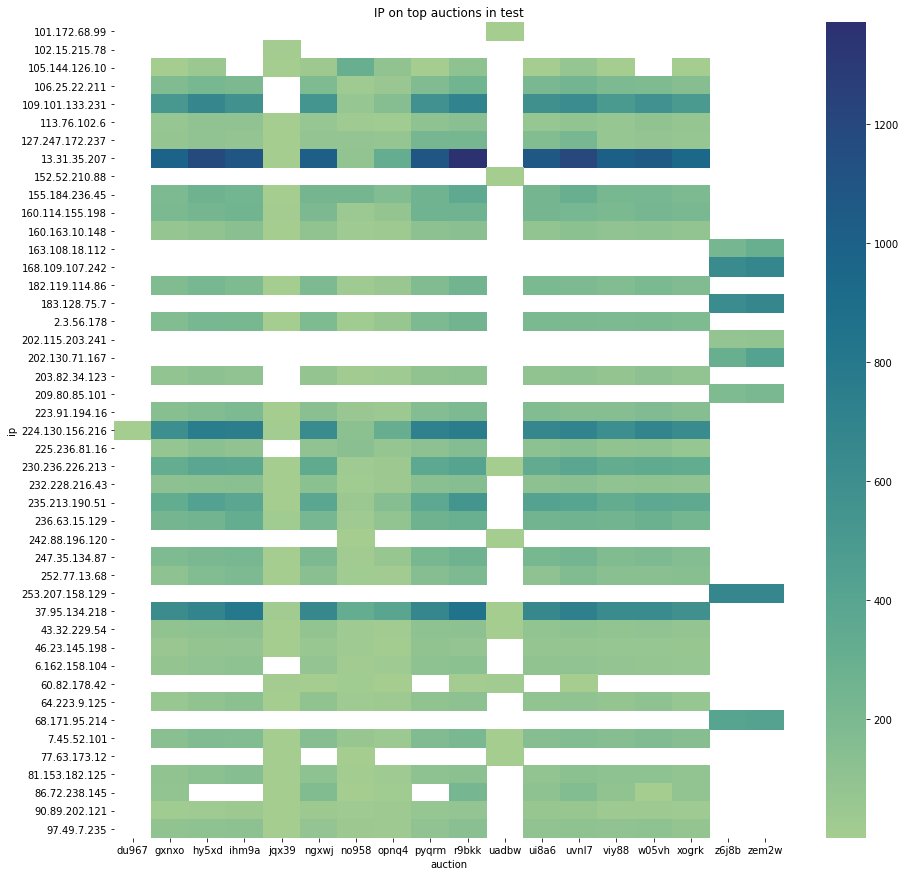

In [ ]:
auction_top = df_bids_test.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
ip_top = df_bids_test.groupby(['ip']).size().reset_index(name="count").sort_values('count',ascending=False)[:50]['ip'].values

tmp = df_bids_test[(df_bids_test['auction'].isin(auction_top)) & (df_bids_test['ip'].isin(ip_top))]\
.groupby(['auction','ip']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="ip").T,cmap="crest",ax=ax)
ax.set_title("IP on top auctions in test")

Text(0.5, 1.0, 'URL on top auctions in train')

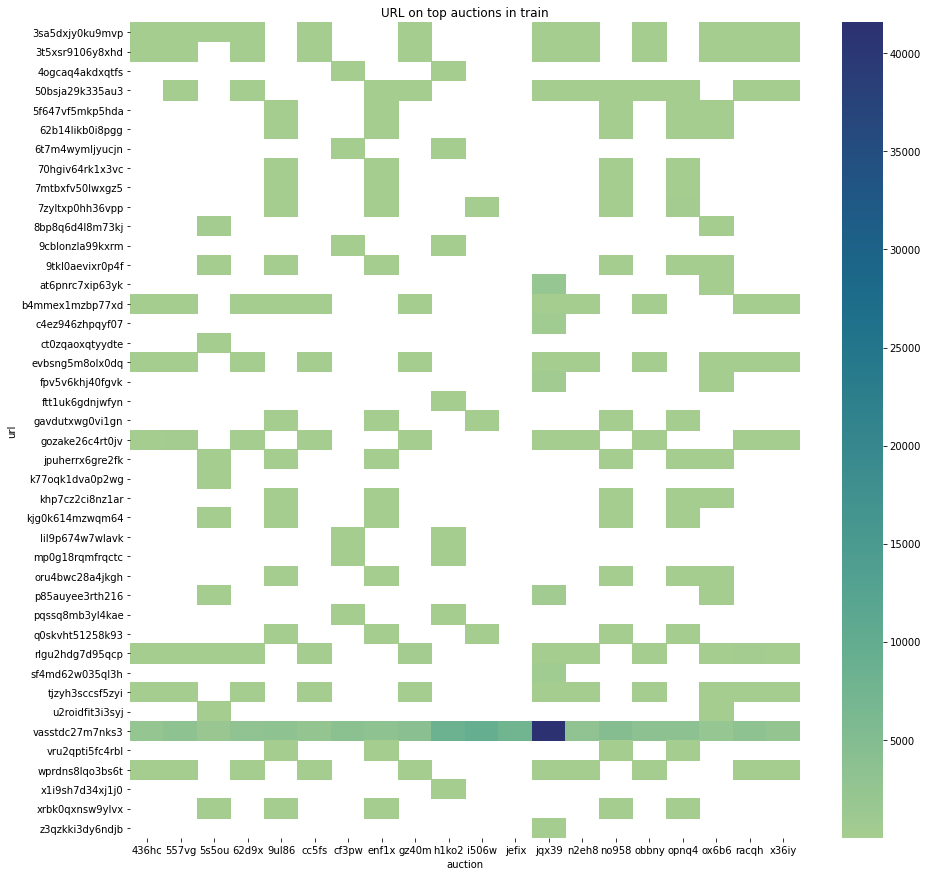

In [ ]:
auction_top = df_bids_train.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
url_top = df_bids_train.groupby(['url']).size().reset_index(name="count").sort_values('count',ascending=False)[:50]['url'].values

tmp = df_bids_train[(df_bids_train['auction'].isin(auction_top)) & (df_bids_train['url'].isin(url_top))]\
.groupby(['auction','url']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="url").T,cmap="crest",ax=ax)
ax.set_title("URL on top auctions in train")

Text(0.5, 1.0, 'URL on top auctions in test')

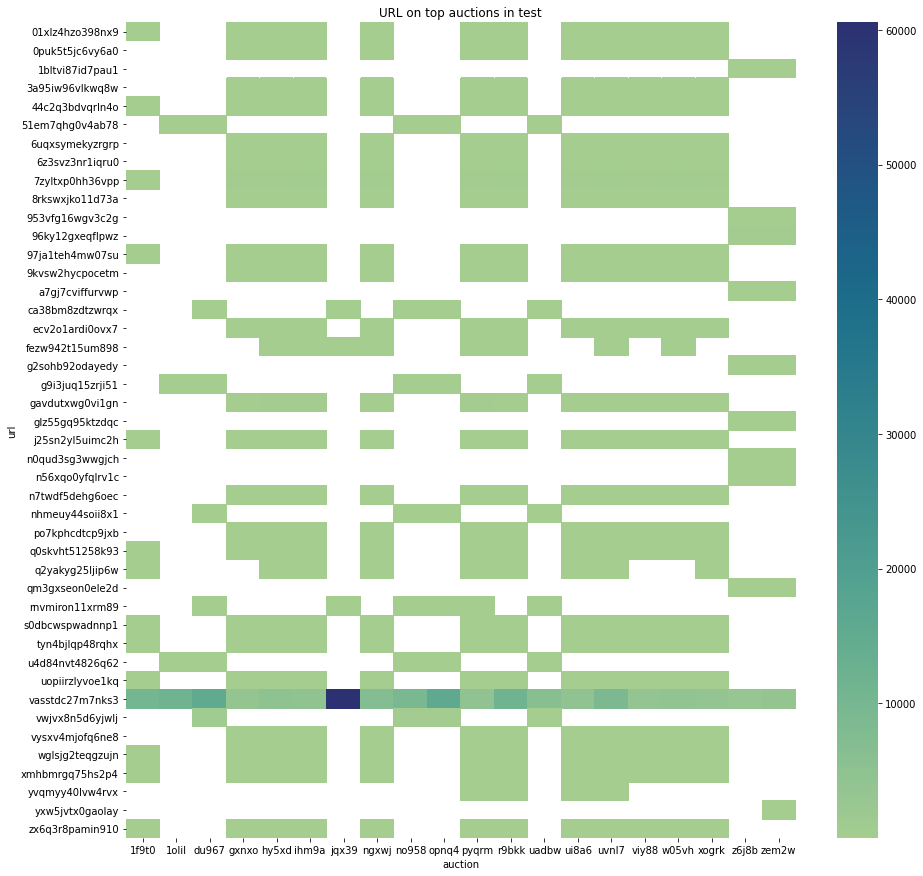

In [ ]:
auction_top = df_bids_test.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values
url_top = df_bids_test.groupby(['url']).size().reset_index(name="count").sort_values('count',ascending=False)[:50]['url'].values

tmp = df_bids_test[(df_bids_test['auction'].isin(auction_top)) & (df_bids_test['url'].isin(url_top))]\
.groupby(['auction','url']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="url").T,cmap="crest",ax=ax)
ax.set_title("URL on top auctions in test")

Text(0.5, 1.0, 'Hour on top auctions in train')

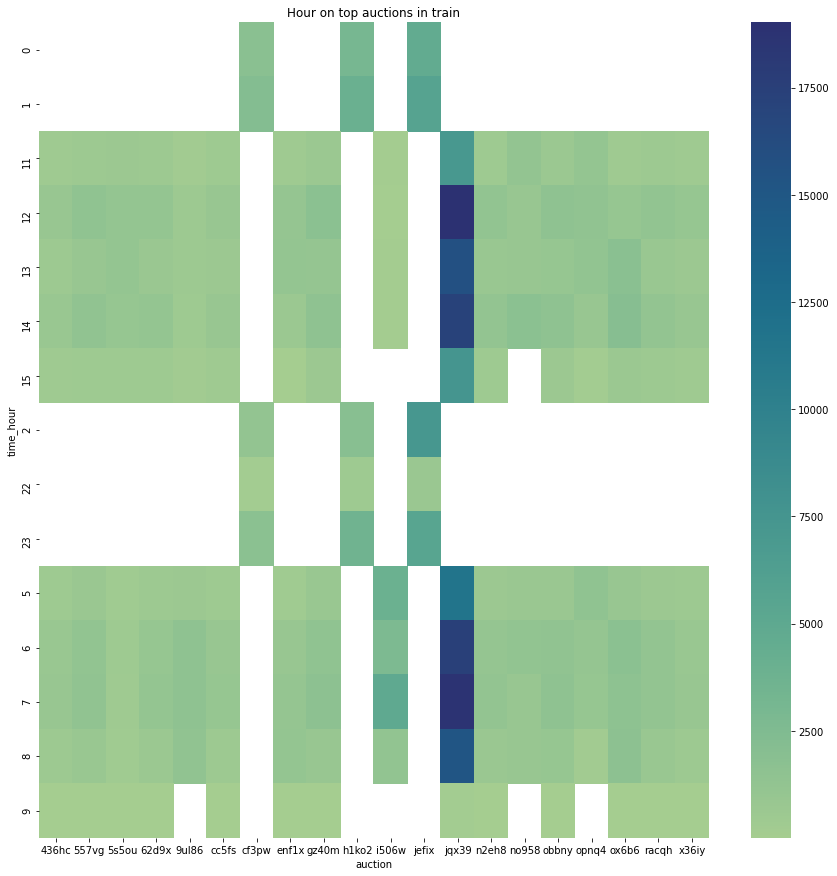

In [ ]:
auction_top = df_bids_train.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values

tmp = df_bids_train[(df_bids_train['auction'].isin(auction_top))]\
.groupby(['auction','time_hour']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="time_hour").T,cmap="crest",ax=ax)
ax.set_title("Hour on top auctions in train")

Text(0.5, 1.0, 'Hour on top auctions in Test')

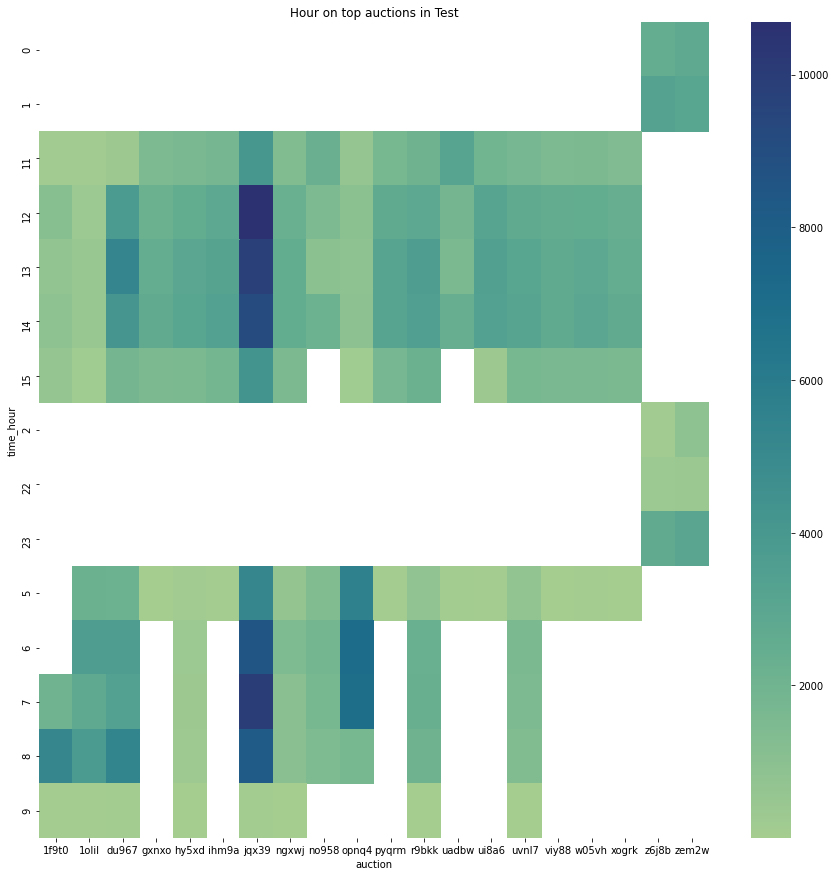

In [ ]:
auction_top = df_bids_test.groupby(['auction']).size().reset_index(name="count").sort_values('count',ascending=False)[:20]['auction'].values

tmp = df_bids_test[(df_bids_test['auction'].isin(auction_top))]\
.groupby(['auction','time_hour']).size().reset_index(name="count").sort_values('count',ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.pivot_table(tmp,values="count",index="auction",columns="time_hour").T,cmap="crest",ax=ax)
ax.set_title("Hour on top auctions in Test")

# Feature Selection and Modeling

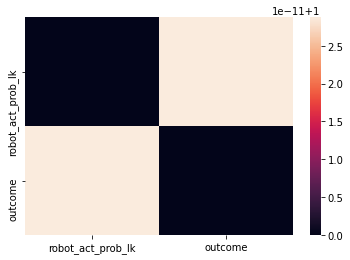

In [ ]:
sns.heatmap(df_bids_train[['robot_act_prob_lk','outcome']].corr())

In [ ]:
df_bids_train.columns

Index(['bidder_id', 'device', 'continent_name', 'country_name', 'country',
       'ip', 'time_hour', 'auction', 'url', 'merchandise', 'robot_act_prob_lk',
       'outcome', 'data'],
      dtype='object')

In [ ]:
df_bids_test.columns

Index(['bidder_id', 'device', 'continent_name', 'country_name', 'country',
       'ip', 'time_hour', 'auction', 'url', 'merchandise', 'robot_act_prob_lk',
       'actual_outcome', 'data'],
      dtype='object')

In [ ]:
df_bids_train = df_bids_train[['bidder_id', 'device', 'continent_name', 'country','ip', 'time_hour', 'auction', 
                               'url', 'merchandise', 'outcome']]

df_bids_test = df_bids_test[['bidder_id', 'device', 'continent_name', 'country','ip', 'time_hour', 'auction', 
                             'url', 'merchandise', 'actual_outcome']]

print(df_bids_train.dtypes)
print('*'*50)
print(df_bids_test.dtypes)

bidder_id         object
device            object
continent_name    object
country           object
ip                object
time_hour         object
auction           object
url               object
merchandise       object
outcome            int64
dtype: object
**************************************************
bidder_id         object
device            object
continent_name    object
country           object
ip                object
time_hour         object
auction           object
url               object
merchandise       object
actual_outcome     int64
dtype: object


In [ ]:
df_bids_train['outcome'].value_counts()

0    1217422
1     145555
Name: outcome, dtype: int64

In [ ]:
df_bids_test['actual_outcome'].value_counts()

0    1194230
1     236005
Name: actual_outcome, dtype: int64

In [ ]:
print(df_bids_train.shape)
df_bids_train.drop_duplicates(inplace=True)
print(df_bids_train.shape)

(1362977, 10)
(1362977, 10)


In [249]:
print(df_bids_test.shape)
df_bids_test.drop_duplicates(inplace=True)
print(df_bids_test.shape)

(1430235, 10)
(1430235, 10)


## Modeling